In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings('ignore')

## EDA

In [8]:
df = pd.read_csv("news 2.csv")

In [9]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


Null value does not exist within the dataset.

In [11]:
X = df.drop(['Unnamed: 0','label'], axis=1)
y = df['label']

In [12]:
df["words_used"] = np.nan

In [13]:
## See how may words are used per text
for i in range(len(df.text)-1):
    df['words_used'].iloc[i] = len(df['text'].iloc[i].split())

In [14]:
len(df.text)

6335

In [15]:
df.head()

,Unnamed: 0,title,text,label,words_used
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,1296.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,446.0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,431.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,404.0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,317.0


In [16]:
df_words = df.groupby('label').agg({'words_used':['mean', 'median', 'std', 'min', 'max']})

In [17]:
for i in range(len(df.text)-1):
    print(len(df['text'].iloc[i].split()))

1296
446
431
404
317
2346
553
123
2354
710
543
399
212
53
17
3147
142
282
1155
281
759
203
728
1476
816
1234
332
295
585
695
28
533
768
323
1233
356
349
259
216
509
1654
481
62
288
309
533
597
14
191
198
3571
1048
32
31
341
107
843
1117
30
410
191
28
510
444
931
844
977
819
1406
323
1173
449
1082
197
207
253
1037
1251
137
222
645
56
1611
1476
4218
605
331
710
826
1011
17
297
367
564
562
498
4149
739
1236
9
1311
30
1260
1138
769
1221
0
485
1698
584
715
1026
353
491
151
693
496
508
829
715
860
267
1152
354
220
1191
1317
487
665
558
666
341
213
697
82
199
899
4678
2443
553
257
308
685
311
17
2081
874
238
785
1069
19
183
254
1301
782
103
444
17
135
254
1068
738
1078
62
351
628
1249
760
2233
299
347
74
191
366
567
676
957
1820
5515
472
483
65
526
378
669
665
794
1422
430
897
857
255
1060
641
335
122
1272
243
1324
626
11
25
978
1511
83
485
2700
511
1491
661
856
767
1487
205
115
567
801
1204
938
48
4279
1547
39
640
779
408
120
337
24
345
1287
304
245
28
251
934
502
1558
6
818
1437
1616
499
12

708
639
783
288
594
17
29
21
936
385
382
985
1904
160
282
383
1072
69
1652
364
1682
580
632
407
433
401
1079
257
515
250
486
293
842
521
756
648
4153
788
1432
973
87
2392
265
261
216
224
810
729
1555
351
733
369
315
470
2044
1479
312
558
282
127
393
667
5650
967
1087
70
690
2
1133
592
379
627
2152
595
240
381
179
473
775
2182
237
237
1658
743
731
71
903
11
20
1289
480
1037
1127
184
309
224
1418
400
2138
175
316
29
1226
1151
337
664
336
429
1113
194
1584
709
2076
378
381
172
1018
401
1296
433
1737
82
570
770
1067
564
494
347
361
321
633
976
1200
1281
17
951
0
339
1451
812
1130
389
965
1112
55
1519
758
1486
287
523
266
693
384
957
8
2246
654
416
689
1397
1404
478
214
1396
793
500
1091
424
834
24
371
2265
1444
223
642
188
3124
434
540
1065
192
1414
723
733
639
799
458
1421
1080
2530
203
821
3702
772
481
152
819
669
563
98
1163
1227
762
207
595
1029
376
188
385
477
331
13
643
886
1050
830
486
1620
297
2302
692
1091
304
450
871
439
1200
86
59
178
316
469
25
1196
1644
90
330
16
445
1005
453


550
871
2020
1311
1312
540
3616
110
208
300
436
834
441
1564
966
1671
237
744
183
15
193
834
352
792
760
262
73
758
565
459
17
272
4182
40
1119
404
212
744
496
671
45
611
362
346
651
166
691
740
4254
17
3835
972
36
17
598
572
127
746
2843
905
196
3301
888
151
901
497
554
2055
83
1064
363
689
1769
1464
372
348
264
80
879
1670
865
1255
283
907
914
506
580
480
1376
698
1487
1037
366
1017
1312
163
45
167
88
337
1016
1344
866
956
176
34
1983
85
28
750
240
796
1111
391
1312
688
652
465
1495
158
482
890
1373
782
241
113
347
55
766
196
813
797
324
754
511
1396
720
715
260
263
361
252
850
27
298
54
936
1322
1161
815
720
1432
298
1171
874
481
2608
31
716
341
377
284
1979
646
1852
1100
35
379
1784
73
643
2008
1136
247
1160
1546
202
232
1672
1079
60
208
633
581
17
1045
0
1161
817
326
643
449
360
783
141
56
553
454
1464
375
225
837
493
1226
624
497
644
590
346
1563
409
346
464
998
1755
609
108
510
1046
537
260
273
399
581
1044
847
719
4290
1275
1638
716
1642
240
933
1336
256
372
151
438
822
433
209

In [18]:
res = len(df['text'].iloc[1].split())

In [19]:
df_words

words_used                                 
             mean median         std  min      max
label                                             
FAKE   679.129267  421.0  958.962790  0.0  20891.0
REAL   873.272871  771.0  722.597043  7.0   7602.0

FAKE news articles contains less mean & median number of words whereas their standard deviation is a lot larger indicating they have more versatility in lengh of an article.

<AxesSubplot:xlabel='label', ylabel='words_used'>

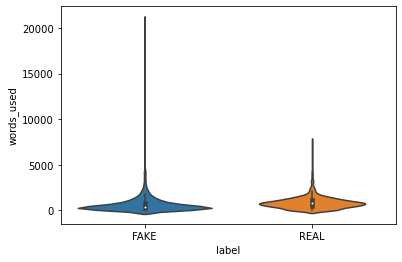

In [20]:
sns.violinplot(x='label', y='words_used', data=df,)

<AxesSubplot:xlabel='words_used', ylabel='Count'>

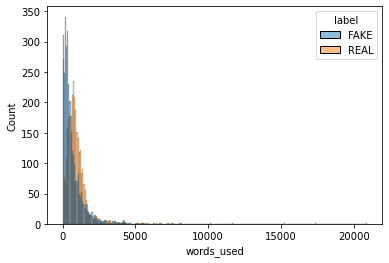

In [21]:
sns.histplot(data=df, x='words_used', hue = "label")

<AxesSubplot:xlabel='label', ylabel='words_used'>

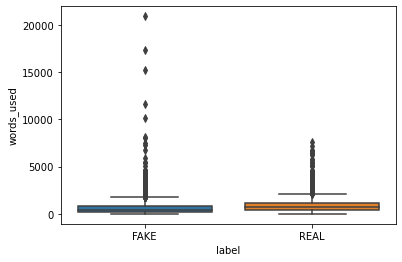

In [22]:
sns.boxplot(x='label', y='words_used', data=df)

In [23]:
df['words_used']

0       1296.0
1        446.0
2        431.0
3        404.0
4        317.0
         ...  
6330     642.0
6331    2183.0
6332    1947.0
6333    1120.0
6334       NaN
Name: words_used, Length: 6335, dtype: float64

## 2. Modeling

Get a holdout set that you don't touch. (about 20% having the ratio that is present in real world)<br>
So when performing cross validation, it should be the same ratio.

Do a split, do not touch holdout set, and evaluate 

### Splitting Dataset for Modeling.

In [24]:
X = df['text']
y = df['label']

In [25]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=7)

In [44]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', 
                                 max_df=0.7,
                                 min_df=5,)

#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test) 

In [46]:
print('TF-IDF Train:',tfidf_train.shape)
print('TF-IDF Test:',tfidf_test.shape)

TF-IDF Train: (5068, 21382)
TF-IDF Test: (1267, 21382)


In [ ]:
#feature_names = tfidf_vectorizer.get_feature_names()

In [70]:
#feature_names = tfidf_vectorizer.get_feature_names()|
#dense = tfidf_train.todense()
#denselist = dense.tolist()
#df_2 = pd.DataFrame(denselist, columns = feature_names)

## 2.1 Modeling

### 2.1.1 Decision Tree Model

In [53]:
Tree_clf = DecisionTreeClassifier()

In [54]:
# Fit the model to the TF-IDF features
Tree_clf = Tree_clf.fit(tfidf_train, y_train)

In [75]:
# Perform Cross Validation
k_fold = 10
Tree_cv_score = cross_val_score(estimator=Tree_clf, X=tfidf_train,
                        y=y_train, cv=k_fold)

In [71]:
Tree_cv_core

array([0.82840237, 0.81459566, 0.81262327, 0.80473373, 0.80276134,
       0.81656805, 0.80078895, 0.81656805, 0.81818182, 0.81620553])

K-fold Cross Validation Score seems to be uniform and accurate.

In [56]:
#DataFlair - Predict on the test set and calculate accuracy
Tree_pred = Tree_clf.predict(tfidf_test)

### 2.1.2 Decision Tree Model Evaluation

In [59]:
Tree_tfidf_score=accuracy_score(y_test,Tree_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfidf_score)

Decision Tree TF-IDF accuracy score: 0.8105761641673244


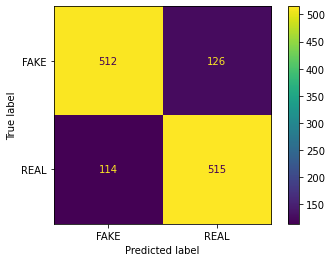

In [62]:
Tree_cm = plot_confusion_matrix(Tree_clf, tfidf_test, y_test);

Result seems not too bad!

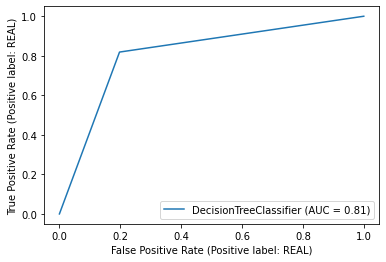

In [63]:
Tree_roc = plot_roc_curve(Tree_clf ,tfidf_test,y_test)

In [78]:
Tree_tfidf_report = classification_report(y_test, Tree_pred, target_names = ['FAKE','REAL'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

        FAKE       0.82      0.80      0.81       638
        REAL       0.80      0.82      0.81       629

    accuracy                           0.81      1267
   macro avg       0.81      0.81      0.81      1267
weighted avg       0.81      0.81      0.81      1267

